# Progetto di Programmazione di Applicazioni Data Intensive: Rilevamento Frodi su Carte di Credito

**Autore:** Alessandro Valmori, alessandro.valmori2@studio.unibo.it, 0001089308
**Data:** 25 Maggio 2025
**Corso:** Programmazione di Applicazioni Data Intensive

## 1. Introduzione e Obiettivo del Progetto

Questo progetto si concentra sull'analisi di un dataset di transazioni con carte di credito al fine di addestrare e validare modelli di classificazione capaci di identificare transazioni fraudolente. Le frodi con carta di credito rappresentano un problema significativo per le istituzioni finanziarie e i consumatori, rendendo cruciale lo sviluppo di sistemi di rilevamento efficaci.

L'obiettivo principale è esplorare il dataset, preparare i dati per il machine learning, addestrare almeno due (preferibilmente tre o più) modelli di classificazione, valutarne le performance con metriche appropriate (data la natura sbilanciata del problema) e ottimizzare gli iperparametri di almeno un modello.

Il dataset utilizzato è "Credit Card Fraud Detection" disponibile su Kaggle, noto per il suo forte sbilanciamento tra classi (pochissime frodi rispetto alle transazioni legittime).

**Struttura del Notebook:**
1.  Introduzione e Obiettivo del Progetto
2.  Setup dell'Ambiente e Caricamento Librerie
3.  Descrizione e Caricamento del Dataset
4.  Analisi Esplorativa dei Dati (EDA)
5.  Preparazione dei Dati per il Machine Learning
6.  Addestramento e Validazione dei Modelli di Classificazione
    * 6.1 Logistic Regression (Baseline)
    * 6.2 Random Forest Classifier
    * 6.3 XGBoost Classifier (Modello Aggiuntivo)
7.  Ottimizzazione degli Iperparametri (con RandomizedSearchCV)
8.  Confronto Finale dei Modelli e Conclusioni

## 2. Setup dell'Ambiente e Caricamento Librerie

In questa sezione, importiamo tutte le librerie Python necessarie per l'analisi dei dati, la visualizzazione, il preprocessing, la modellazione e la valutazione.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline


## 3. Descrizione e Caricamento del Dataset

Utilizziamo il dataset "Credit Card Fraud Detection" da Kaggle. Questo dataset contiene transazioni effettuate con carte di credito europee nel settembre 2013. Presenta 284.807 transazioni, di cui solo 492 sono fraudolente (circa lo 0.172%).
Le feature `V1` a `V28` sono il risultato di una trasformazione PCA applicata ai dati originali per ragioni di confidenzialità. Le uniche feature non trasformate da PCA sono `Time` (secondi trascorsi tra ogni transazione e la prima transazione nel dataset) e `Amount` (l'importo della transazione). La variabile target è `Class`, che vale 1 in caso di frode e 0 altrimenti.

Procediamo con il caricamento e una prima ispezione del dataset.

In [4]:
# Caricamento del dataset
try:
    df = pd.read_csv('creditcard.csv')
    print("Dataset caricato con successo.")
    print(f"Dimensioni del dataset: {df.shape}")
except FileNotFoundError:
    print("Errore: creditcard.csv non trovato. Assicurati che il file sia nella directory corretta.")
    # Qui potresti aggiungere istruzioni per scaricare il dataset se non presente
    # exit() # O gestire l'errore come preferisci

Dataset caricato con successo.
Dimensioni del dataset: (284807, 31)


## 4. Analisi Esplorativa dei Dati (EDA)

L'Analisi Esplorativa dei Dati (EDA) è fondamentale per comprendere la struttura del dataset, le distribuzioni delle variabili, le correlazioni e identificare eventuali problemi o pattern interessanti.

### 4.1. Analisi della Variabile Target (`Class`)
Iniziamo analizzando la distribuzione della variabile target per quantificare lo sbilanciamento.

In [5]:
# Visualizza le prime righe
print("\nPrime 5 righe del dataset:")
print(df.head())

# Informazioni generali sul dataset
print("\nInformazioni sul dataset:")
df.info()

# Verifica di valori nulli
print("\nValori nulli per colonna:")
print(df.isnull().sum())

# Eventuale eliminazione di colonne (se ce ne fossero di palesemente non informative)
# In questo dataset, tutte le colonne sono rilevanti o da investigare.
# Ad esempio, 'Time' potrebbe essere trasformata o eliminata se non utile.


Prime 5 righe del dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    


Distribuzione della variabile target 'Class':
Class
0    284315
1       492
Name: count, dtype: int64
Percentuale frodi: 0.17%


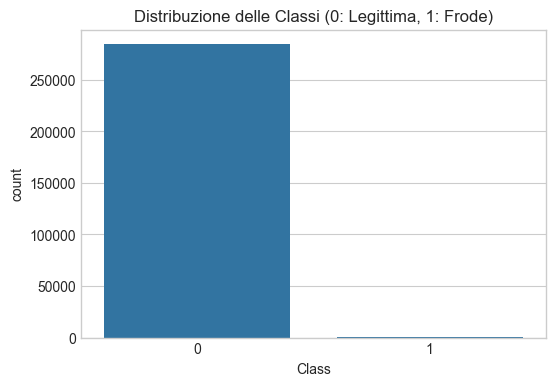

In [6]:
# Distribuzione della variabile target 'Class'
print("\nDistribuzione della variabile target 'Class':")
class_counts = df['Class'].value_counts()
print(class_counts)
print(f"Percentuale frodi: {class_counts[1] / sum(class_counts) * 100:.2f}%")

plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Distribuzione delle Classi (0: Legittima, 1: Frode)')
plt.show()

Come osservato, il dataset è estremamente sbilanciato: solo lo 0.17% delle transazioni sono etichettate come fraudolente. Questo sbilanciamento è una caratteristica cruciale che influenzerà la scelta delle metriche di valutazione e delle tecniche di modellazione (ad esempio, la necessità di tecniche di ricampionamento come SMOTE o l'uso di pesi di classe).

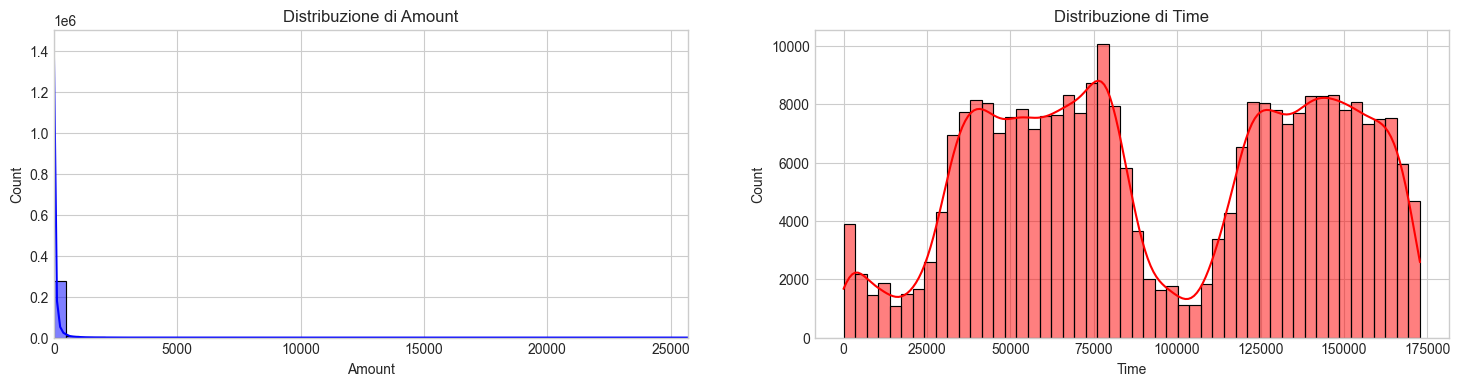

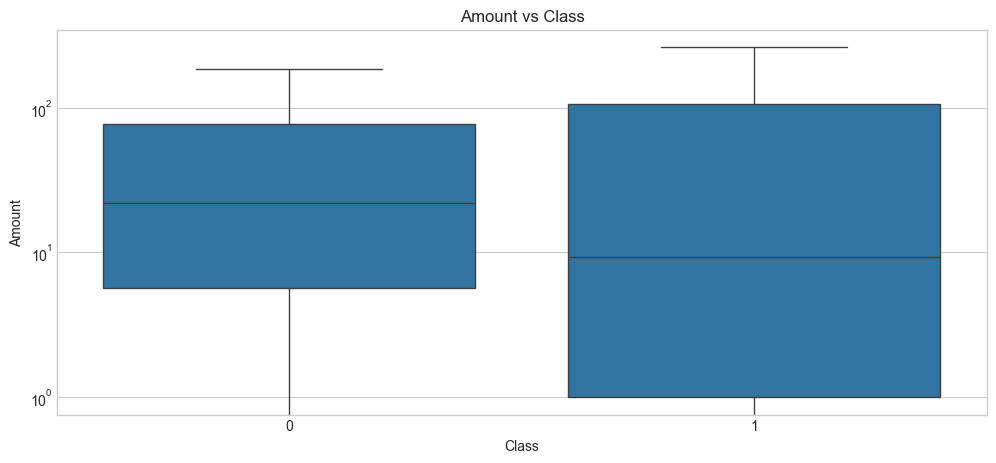

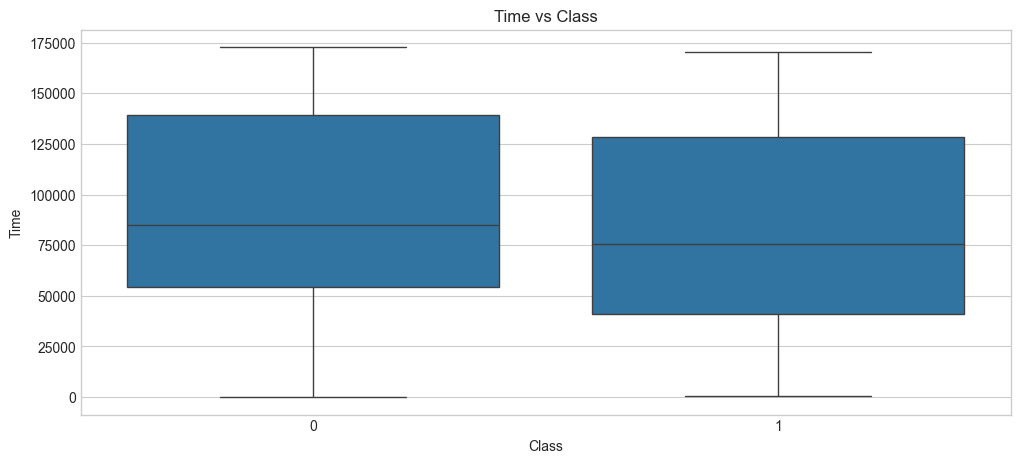

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], ax=ax[0], color='b', bins=50, kde=True)
ax[0].set_title('Distribuzione di Amount')
ax[0].set_xlim([min(df['Amount']), max(df['Amount'])]) # Potrebbe essere necessario limitare xlim per visualizzare meglio

sns.histplot(df['Time'], ax=ax[1], color='r', bins=50, kde=True)
ax[1].set_title('Distribuzione di Time')
plt.show()

# Confronto di Amount e Time per transazioni fraudolente e non
plt.figure(figsize=(12, 5))
sns.boxplot(x='Class', y='Amount', data=df, showfliers=False) # showfliers=False per non mostrare gli outlier e vedere meglio le box
plt.title('Amount vs Class')
plt.yscale('log') # Scala logaritmica può aiutare per 'Amount'
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x='Class', y='Time', data=df)
plt.title('Time vs Class')
plt.show()

**Osservazioni su `Time` e `Amount`:**
* **Amount:** La distribuzione degli importi delle transazioni è fortemente asimmetrica a destra (right-skewed), con la maggior parte delle transazioni di piccolo importo e alcune transazioni di importo molto elevato. Il boxplot, specialmente con scala logaritmica sull'asse y, mostra che le transazioni fraudolente tendono ad avere una distribuzione degli importi leggermente diversa, sebbene ci sia una notevole sovrapposizione. L'uso di `showfliers=False` nel boxplot aiuta a visualizzare meglio il corpo principale della distribuzione senza essere distratti dagli outlier estremi.
* **Time:** La feature `Time` rappresenta i secondi trascorsi dalla prima transazione. L'istogramma mostra un pattern bimodale, che potrebbe indicare cicli di attività giornalieri (es. meno transazioni durante la notte). Il boxplot che confronta `Time` per le due classi non rivela pattern immediatamente evidenti o distintivi per le frodi basati solo su questa feature grezza, anche se si nota una leggera differenza nella mediana. Per questo progetto, data la sua natura (secondi trascorsi), e la difficoltà di interpretazione diretta senza conoscere il momento esatto di inizio, procederemo inizialmente scalando questa feature. Ulteriori analisi o feature engineering (es. trasformazione in ore del giorno) potrebbero essere considerate in sviluppi futuri ma sono fuori dallo scopo minimo di questo progetto.

### 4.3. Analisi delle Correlazioni
Esaminiamo la correlazione tra le features e la variabile target. Poiché le features `V1-V28` sono componenti PCA, ci aspettiamo che siano largamente incorrelate tra loro. La correlazione con la classe target può invece darci indicazioni sulle features potenzialmente più informative.


Correlazione delle features con la classe target:
Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


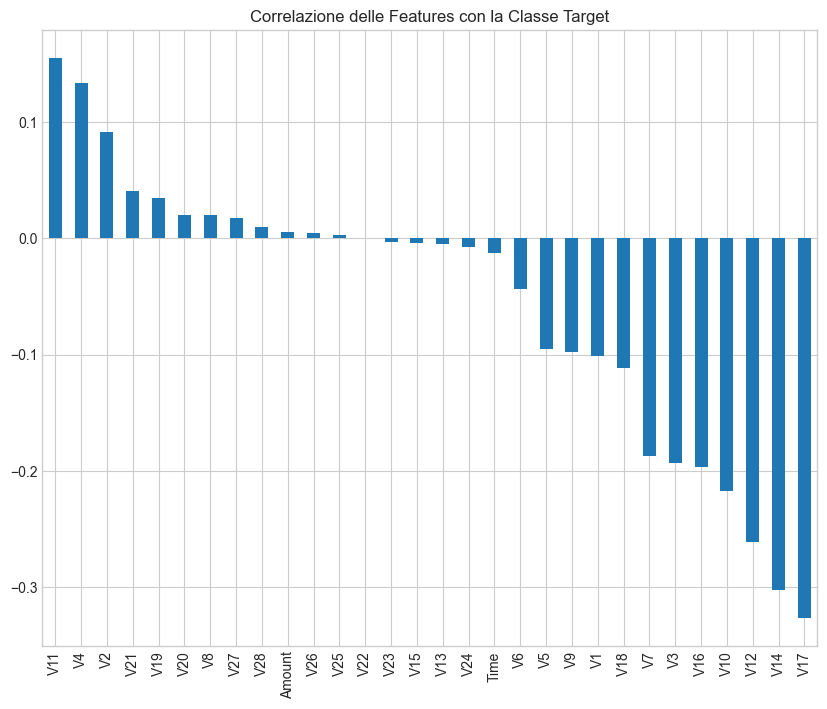

In [8]:
# Matrice di correlazione (escludendo Time per ora, V1-V28 dovrebbero essere incorrelate)
# Potrebbe essere utile scalare Amount prima di questa analisi
# df_scaled_amount = df.copy()
# df_scaled_amount['Amount'] = RobustScaler().fit_transform(df_scaled_amount['Amount'].values.reshape(-1,1))

# plt.figure(figsize=(18, 14))
# sns.heatmap(df_scaled_amount.corr(), annot=False, cmap='coolwarm', linewidths=.5)
# plt.title('Matrice di Correlazione (Amount scalato)')
# plt.show()

# Correlazione con la variabile target 'Class'
correlation_with_target = df.corr()['Class'].sort_values(ascending=False)
print("\nCorrelazione delle features con la classe target:")
print(correlation_with_target)

plt.figure(figsize=(10, 8))
correlation_with_target.drop('Class').plot(kind='bar')
plt.title('Correlazione delle Features con la Classe Target')
plt.show()

**Osservazioni sulle Correlazioni:**
Il grafico a barre mostra le correlazioni di Pearson tra ciascuna feature e la variabile `Class`.
* Alcune features `V` mostrano una correlazione negativa più marcata con la classe `Class` (es. `V17`, `V14`, `V12`, `V10`). Questo suggerisce che valori più bassi di queste features sono associati a una maggiore probabilità di frode.
* Altre features `V` (es. `V11`, `V4`, `V2`) mostrano una correlazione positiva, indicando che valori più alti potrebbero essere associati a frodi.
* `Amount` e `Time` mostrano correlazioni molto deboli con `Class`. Tuttavia, la correlazione lineare non cattura relazioni non lineari, che potrebbero comunque esistere. Lo scaling di `Amount` e `Time` sarà importante per i modelli sensibili alla scala delle features.

### 4.4. Distribuzione di Alcune Features PCA per Classe
Visualizziamo le distribuzioni di densità (KDE) per alcune delle features PCA che hanno mostrato una correlazione più significativa con la classe target, separando le transazioni legittime da quelle fraudolente. Questo può aiutarci a capire se ci sono differenze visibili nelle distribuzioni.

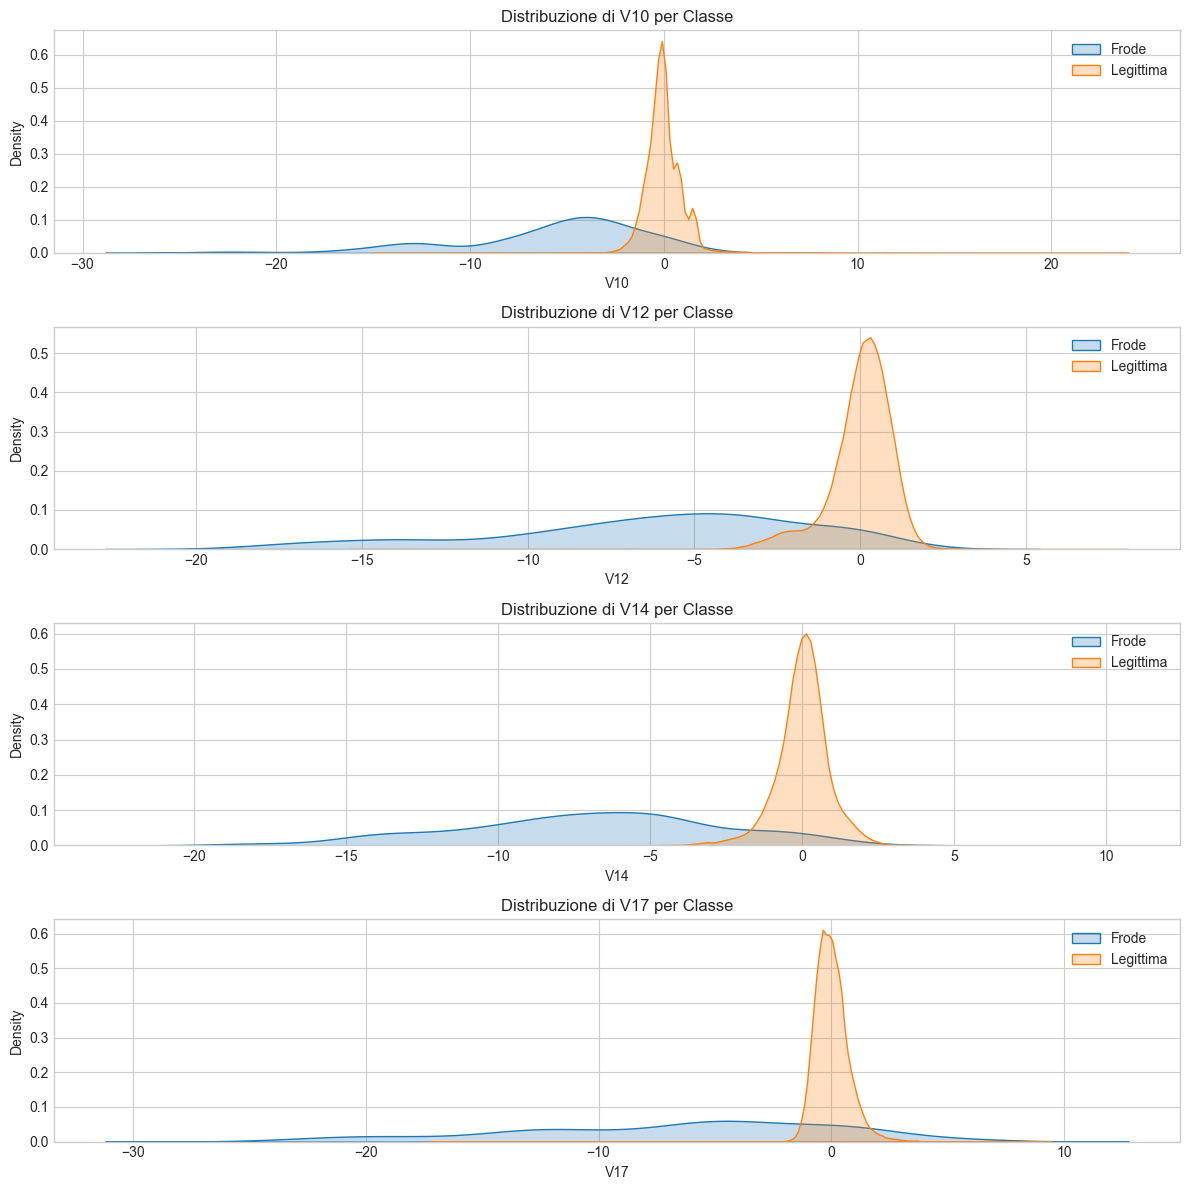

In [9]:
# Esempio: plot di alcune features V1-V28 per le due classi
var_to_plot = ['V10', 'V12', 'V14', 'V17'] # Features spesso indicative
plt.figure(figsize=(12, len(var_to_plot)*3))
for i, var in enumerate(var_to_plot):
    plt.subplot(len(var_to_plot), 1, i+1)
    sns.kdeplot(df[var][df.Class == 1], label="Frode", fill=True)
    sns.kdeplot(df[var][df.Class == 0], label="Legittima", fill=True)
    plt.title(f'Distribuzione di {var} per Classe')
    plt.legend()
plt.tight_layout()
plt.show()

## 5. Preparazione dei Dati per il Machine Learning

Questa fase include diversi passaggi cruciali:
1.  **Scaling delle Features**: Le features `Time` e `Amount` sono su scale molto diverse rispetto alle features PCA `V1-V28` (che sono già standardizzate). È importante scalarle per evitare che dominino i modelli sensibili alla scala (es. Logistic Regression, SVM, Reti Neurali). Useremo `RobustScaler`, che è meno sensibile agli outlier rispetto a `StandardScaler`.
2.  **Separazione Features e Target**: Isoleremo la variabile target `Class` (y) dalle variabili predittive (X).
3.  **Suddivisione in Training e Test Set**: Divideremo il dataset in un insieme di addestramento e un insieme di test. È fondamentale usare la stratificazione sulla variabile target (`stratify=y`) per assicurare che la proporzione di classi fraudolente e legittime sia mantenuta in entrambi i set, data la forte imbalanced nature.
4.  **Gestione dello Sbilanciamento delle Classi**: Applicheremo una tecnica di ricampionamento, specificamente SMOTE (Synthetic Minority Over-sampling Technique), *solo sul training set*. SMOTE genera campioni sintetici per la classe minoritaria (frodi) per bilanciare la distribuzione delle classi, aiutando il modello a imparare meglio le caratteristiche delle frodi senza semplicemente predire sempre la classe maggioritaria. È cruciale applicare SMOTE *dopo* la suddivisione in train/test per evitare data leakage (informazioni del test set che influenzano l'addestramento).

In [10]:
# Scaling delle colonne 'Amount' e 'Time'
# RobustScaler è meno sensibile agli outlier rispetto a StandardScaler
rob_scaler = RobustScaler()

df_prepared = df.copy()
df_prepared['scaled_amount'] = rob_scaler.fit_transform(df_prepared['Amount'].values.reshape(-1,1))
df_prepared['scaled_time'] = rob_scaler.fit_transform(df_prepared['Time'].values.reshape(-1,1))

# Rimuovere le colonne originali 'Time' e 'Amount'
df_prepared.drop(['Time','Amount'], axis=1, inplace=True)

# Spostare 'Class' alla fine se si preferisce
target_column = df_prepared.pop('Class')
df_prepared.insert(len(df_prepared.columns), 'Class', target_column)

print("\nDataset dopo lo scaling e riordino (prime righe):")
print(df_prepared.head())


Dataset dopo lo scaling e riordino (prime righe):
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26      

In [11]:
X = df_prepared.drop('Class', axis=1)
y = df_prepared['Class']

# Suddivisione in training e test set, stratificando su y per mantenere le proporzioni delle classi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nForma di X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Distribuzione classi in y_train: \n{y_train.value_counts(normalize=True)}")
print(f"Distribuzione classi in y_test: \n{y_test.value_counts(normalize=True)}")


Forma di X_train: (227845, 30), X_test: (56962, 30)
Distribuzione classi in y_train: 
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Distribuzione classi in y_test: 
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [12]:
# Applica SMOTE solo sul training set per evitare data leakage
# NOTA: SMOTE (o altre tecniche di resampling) va applicato DOPO lo split train-test
# e SOLO sul training set.

print(f"\nDistribuzione classi in y_train PRIMA di SMOTE: \n{y_train.value_counts()}")

# Esempio con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Forma di X_train dopo SMOTE: {X_train_smote.shape}")
print(f"Distribuzione classi in y_train DOPO SMOTE: \n{y_train_smote.value_counts()}")

# Si può anche considerare RandomUnderSampler o una combinazione,
# o non applicare resampling e usare pesi di classe nei modelli.
# Per questo progetto, è richiesto di provare almeno una tecnica di resampling.


Distribuzione classi in y_train PRIMA di SMOTE: 
Class
0    227451
1       394
Name: count, dtype: int64
Forma di X_train dopo SMOTE: (454902, 30)
Distribuzione classi in y_train DOPO SMOTE: 
Class
0    227451
1    227451
Name: count, dtype: int64


## 6. Addestramento e Validazione dei Modelli di Classificazione

In questa sezione, addestreremo e valuteremo tre diversi modelli di classificazione:
1.  **Logistic Regression**: Un modello lineare semplice che servirà come baseline.
2.  **Random Forest Classifier**: Un modello basato su ensemble di alberi decisionali, generalmente più potente.
3.  **XGBoost Classifier**: Un'implementazione ottimizzata di gradient boosting, spesso molto performante.

Per la valutazione, data la natura sbilanciata del dataset, ci concentreremo su metriche come:
* **Precision (per la classe frode)**: Di tutte le transazioni predette come frode, quante lo sono realmente? (TP / (TP + FP))
* **Recall (per la classe frode)**: Di tutte le transazioni fraudolente reali, quante sono state identificate correttamente? (TP / (TP + FN)) - Questa è spesso la metrica più importante in questo contesto, poiché mancare una frode (Falso Negativo) è solitamente più costoso di un falso allarme (Falso Positivo).
* **F1-Score (per la classe frode)**: La media armonica di Precision e Recall.
* **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**: Misura la capacità del modello di distinguere tra le classi.
* **AUC-PR (Area Under the Precision-Recall Curve)**: Particolarmente informativa per dataset sbilanciati, rappresenta la media delle precision a diversi valori di soglia.
* **Confusion Matrix**: Per visualizzare il numero di Veri Positivi, Falsi Positivi, Veri Negativi e Falsi Negativi.

Definiamo prima una funzione ausiliaria per calcolare e visualizzare queste metriche.

In [13]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Modello"):
    print(f"--- Valutazione: {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (Fraud): {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall (Fraud): {recall_score(y_true, y_pred, pos_label=1):.4f}") # Molto importante!
    print(f"F1-Score (Fraud): {f1_score(y_true, y_pred, pos_label=1):.4f}")   # Molto importante!
    if y_pred_proba is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_proba[:, 1]):.4f}")
        avg_precision = average_precision_score(y_true, y_pred_proba[:, 1], pos_label=1)
        print(f"Average Precision (AUC-PR): {avg_precision:.4f}") # Molto importante!
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    plt.title('Confusion Matrix')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legittima (0)', 'Frode (1)']))
    print("--------------------------------------\n")
    # Ritornare metriche chiave per il confronto
    return {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_fraud': precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        'recall_fraud': recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        'f1_fraud': f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba[:, 1]) if y_pred_proba is not None else None,
        'auc_pr': average_precision_score(y_true, y_pred_proba[:, 1], pos_label=1) if y_pred_proba is not None else None
    }

# Lista per conservare i risultati dei modelli
model_results = []

### 6.1. Logistic Regression (Baseline)

Iniziamo con un modello di Logistic Regression. Lo addestreremo sul training set bilanciato con SMOTE (`X_train_smote`, `y_train_smote`) e lo valuteremo sul test set originale (`X_test`, `y_test`).

--- Valutazione: Logistic Regression (con SMOTE) ---
Accuracy: 0.9747
Precision (Fraud): 0.0590
Recall (Fraud): 0.9184
F1-Score (Fraud): 0.1109
ROC AUC Score: 0.9714
Average Precision (AUC-PR): 0.7249

Confusion Matrix:


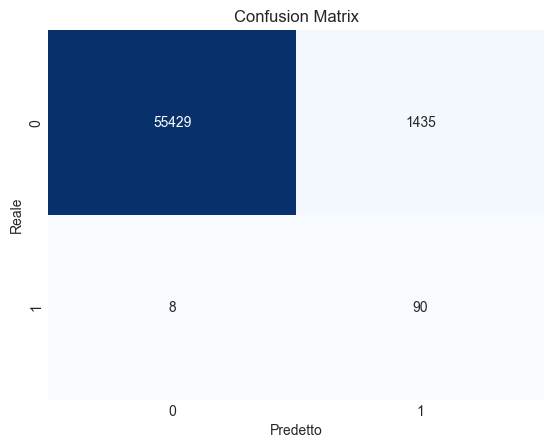


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      0.97      0.99     56864
    Frode (1)       0.06      0.92      0.11        98

     accuracy                           0.97     56962
    macro avg       0.53      0.95      0.55     56962
 weighted avg       1.00      0.97      0.99     56962

--------------------------------------



In [14]:
# Usare i dati del training set con SMOTE
lr_model = LogisticRegression(solver='liblinear', random_state=42) # class_weight='balanced' potrebbe essere un'alternativa a SMOTE
lr_model.fit(X_train_smote, y_train_smote)

y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

results_lr = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression (con SMOTE)")
model_results.append(results_lr)

# Analisi Coefficienti (se interessante, ma con PCA sono meno interpretabili)
# coeff = pd.DataFrame({'feature': X_train.columns, 'coefficient': lr_model.coef_[0]})
# print(coeff.sort_values(by='coefficient', ascending=False))

**Osservazioni sulla Logistic Regression:**
La Logistic Regression, pur essendo un modello semplice, ottiene un **Recall per le frodi molto alto (0.9184)**, il che significa che identifica correttamente quasi il 92% delle transazioni fraudolente reali. Tuttavia, la **Precision per le frodi è estremamente bassa (0.0590)**. Questo indica che il modello genera un gran numero di falsi positivi: molte transazioni legittime vengono erroneamente classificate come frodi per riuscire a catturare quelle reali.
L'**AUC-PR di 0.7249** è un buon punto di partenza, ma l'F1-score basso (0.1109) per le frodi evidenzia il trade-off tra recall e precision. Questo comportamento (alta recall, bassa precision) è tipico quando si applica SMOTE e si usano modelli lineari che cercano di massimizzare la separazione.

### 6.2. Random Forest Classifier

Passiamo ora a un modello più complesso, il Random Forest Classifier. Useremo `class_weight='balanced_subsample'` come parametro per il classificatore, che aiuta a gestire lo sbilanciamento intrinseco durante la costruzione di ciascun albero, anche se stiamo addestrando sui dati bilanciati con SMOTE. Questo può fornire un ulteriore piccolo aiuto. In alternativa, si potrebbe omettere `class_weight` se si usa solo SMOTE.

--- Valutazione: Random Forest (con SMOTE) ---
Accuracy: 0.9995
Precision (Fraud): 0.8778
Recall (Fraud): 0.8061
F1-Score (Fraud): 0.8404
ROC AUC Score: 0.9568
Average Precision (AUC-PR): 0.8667

Confusion Matrix:


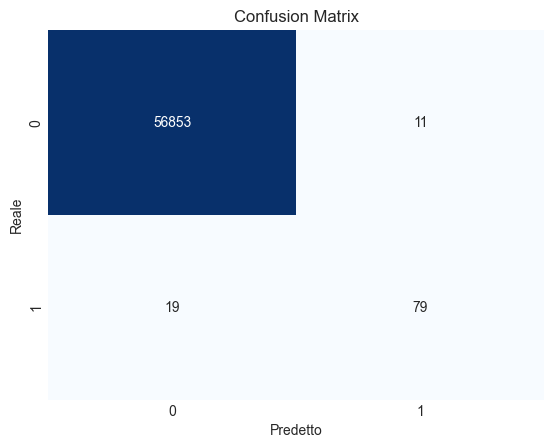


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.88      0.81      0.84        98

     accuracy                           1.00     56962
    macro avg       0.94      0.90      0.92     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


Feature Importances (Random Forest):
         importance
feature            
V14        0.226230
V4         0.103879
V10        0.103472
V17        0.087179
V12        0.079141
V11        0.074552
V3         0.057000
V16        0.044727
V2         0.025516
V7         0.025200


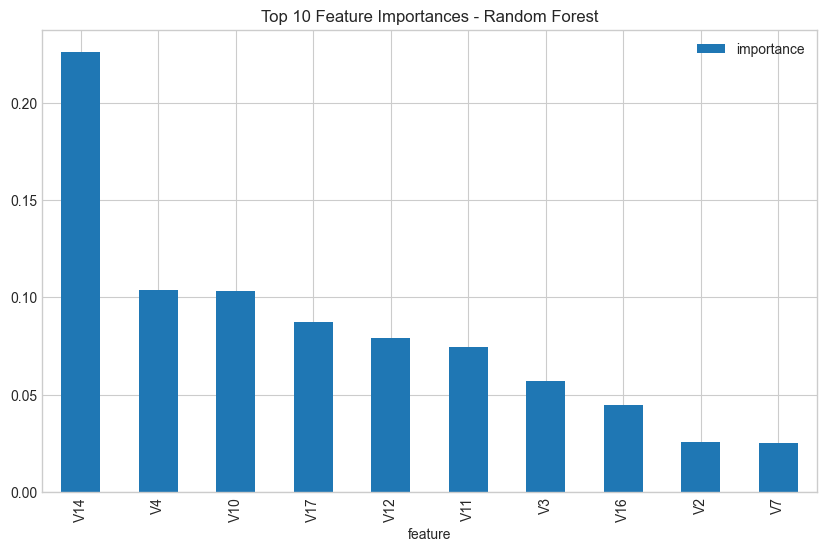

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample') # class_weight per aiutare ulteriormente
# Oppure allenare su dati con SMOTE senza class_weight:
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote) # O X_train, y_train se si usa class_weight

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

results_rf = evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest (con SMOTE)")
model_results.append(results_rf)

# Analisi Feature Importances
importances_rf = pd.DataFrame({'feature': X_train.columns, 'importance': rf_model.feature_importances_})
importances_rf = importances_rf.sort_values('importance', ascending=False).set_index('feature')
print("\nFeature Importances (Random Forest):")
print(importances_rf.head(10))
importances_rf.head(10).plot(kind='bar', figsize=(10,6))
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()

**Osservazioni sul Random Forest:**
Il Random Forest Classifier mostra un miglioramento significativo rispetto alla Logistic Regression su diverse metriche chiave per la classe frode:
* **Precision (Frode): 0.8778** (nettamente superiore al 0.0590 della LR)
* **Recall (Frode): 0.8061** (leggermente inferiore alla LR, ma ancora buono)
* **F1-Score (Frode): 0.8404** (molto più bilanciato e alto)
* **AUC-PR: 0.8667** (migliore della LR)

L'accuracy generale è altissima (0.9995), ma sappiamo che non è la metrica principale qui. La Confusion Matrix mostra che il Random Forest ha solo 11 falsi positivi (transazioni legittime classificate come frode) e 19 falsi negativi (frodi mancate). Questo è un buon equilibrio. Le feature importance indicano che `V14`, `V4`, `V10`, `V17` e `V12` sono tra le più rilevanti per questo modello.

### 6.3. XGBoost Classifier

Infine, addestriamo un XGBoost Classifier, un modello di gradient boosting noto per le sue elevate performance. Lo addestriamo anch'esso sui dati bilanciati con SMOTE.

**Osservazioni su XGBoost Classifier (da inserire dopo l'esecuzione della cella XGBoost):**
*(Qui dovrai commentare i risultati di XGBoost una volta che li avrai. Confronta Precision, Recall, F1-Score e AUC-PR con gli altri due modelli. Analizza anche le feature importance di XGBoost.)*


--- Addestramento XGBoost Classifier (con SMOTE) ---


/home/siralex/.cache/pypoetry/virtualenvs/credit-card-j7SKsNum-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:28:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Valutazione: XGBoost Classifier (con SMOTE) ---
Accuracy: 0.9992
Precision (Fraud): 0.7179
Recall (Fraud): 0.8571
F1-Score (Fraud): 0.7814
ROC AUC Score: 0.9779
Average Precision (AUC-PR): 0.8673

Confusion Matrix:


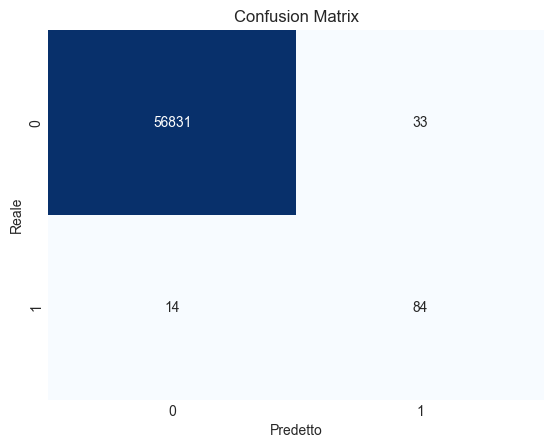


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.72      0.86      0.78        98

     accuracy                           1.00     56962
    macro avg       0.86      0.93      0.89     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


Feature Importances (XGBoost Classifier):
               importance
feature                  
V14              0.580156
V4               0.058297
V8               0.035596
V10              0.030206
V12              0.026982
V13              0.020041
scaled_amount    0.015517
V7               0.015487
V26              0.015414
V15              0.014811


<Figure size 1000x600 with 0 Axes>

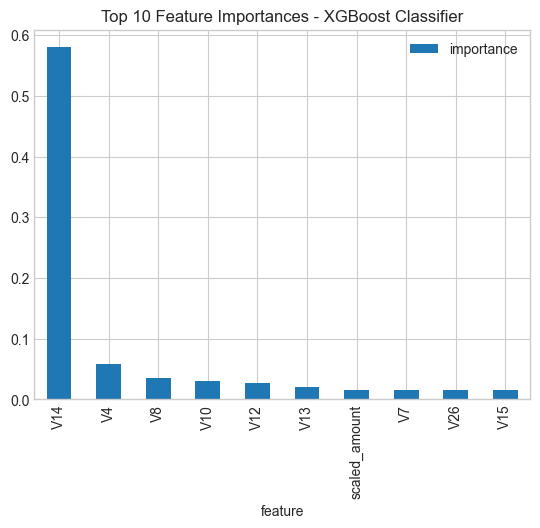

In [18]:
# Aggiungiamo XGBoost come terzo modello
import xgboost as xgb

# Definiamo il modello XGBoost
# Per dataset sbilanciati, scale_pos_weight è un parametro utile se NON si usa SMOTE.
# Dato che usiamo X_train_smote (già bilanciato), non è strettamente necessario,
# ma possiamo comunque usarlo o impostarlo a 1, oppure ometterlo.
# Per coerenza con l'approccio Random Forest dove usiamo SMOTE, alleniamo XGBoost su X_train_smote.
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', # Obiettivo per classificazione binaria
    eval_metric='aucpr',         # Metrica di valutazione per l'early stopping (se usato)
    use_label_encoder=False,     # Per evitare warning con versioni recenti
    random_state=42
)

print("\n--- Addestramento XGBoost Classifier (con SMOTE) ---")
xgb_model.fit(X_train_smote, y_train_smote)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

results_xgb = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost Classifier (con SMOTE)")
model_results.append(results_xgb)

# Analisi Feature Importances per XGBoost
importances_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
importances_xgb = importances_xgb.sort_values('importance', ascending=False).set_index('feature')
print("\nFeature Importances (XGBoost Classifier):")
print(importances_xgb.head(10))

plt.figure(figsize=(10,6))
importances_xgb.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances - XGBoost Classifier')
plt.show()

**Osservazioni su XGBoost Classifier:**
L'XGBoost Classifier ottiene ottime performance, posizionandosi in modo competitivo rispetto al Random Forest:
* **Accuracy: 0.9992** (molto alta, come ci si aspetta, ma non è la metrica primaria).
* **Precision (Frode): 0.7179**. Questo valore è inferiore a quello del Random Forest (0.8778) ma significativamente migliore della Logistic Regression. Indica che circa il 72% delle transazioni segnalate come frode da XGBoost lo sono effettivamente.
* **Recall (Frode): 0.8571**. Questo è un valore di recall molto buono, superiore a quello del Random Forest (0.8061) e della Logistic Regression (0.9184, che però aveva una precision bassissima). Significa che XGBoost identifica correttamente quasi l'86% di tutte le frodi reali.
* **F1-Score (Frode): 0.7814**. Un buon bilanciamento tra precision e recall, leggermente inferiore a quello del Random Forest (0.8404) a causa della precision più bassa.
* **ROC AUC Score: 0.9779** (molto alto).
* **Average Precision (AUC-PR): 0.8673**. Questo valore è eccellente e quasi identico a quello del Random Forest (0.8667), indicando una forte capacità del modello di classificare correttamente le frodi tenendo conto dello sbilanciamento.

La Confusion Matrix mostra che XGBoost ha 33 falsi positivi (legittime classificate come frode) e 14 falsi negativi (frodi mancate). Rispetto al Random Forest (11 FP, 19 FN), XGBoost ha più falsi positivi ma meno falsi negativi, il che si traduce in un recall più alto per le frodi. La scelta tra i due potrebbe dipendere dal costo relativo di FP vs FN.

Le feature importance di XGBoost indicano che `V14` è di gran lunga la feature più importante, seguita da `V4`, `V8`, `V10` e `V12`. C'è una certa coerenza con le feature importanti per il Random Forest, anche se l'ordine e il peso relativo possono variare. È interessante notare che `scaled_amount` appare tra le top 10 per XGBoost.

## 7. Ottimizzazione degli Iperparametri con RandomizedSearchCV

Come richiesto dalle linee guida e data la potenziale lentezza di `GridSearchCV` (come sperimentato), procederemo con `RandomizedSearchCV` per ottimizzare gli iperparametri di uno dei modelli più promettenti. Scegliamo il Random Forest Classifier, che ha già mostrato buone performance di base.

`RandomizedSearchCV` non prova tutte le combinazioni possibili, ma ne campiona un numero fisso (`n_iter`) da uno spazio di parametri specificato (che può includere distribuzioni statistiche). Questo la rende molto più efficiente, specialmente per spazi di ricerca ampi.

L'obiettivo è massimizzare l'**Average Precision (AUC-PR)**, che è una metrica robusta per problemi di classificazione sbilanciata.


Inizio Randomized Search per Random Forest (n_iter=15)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Migliori parametri trovati da RandomizedSearchCV: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 203}
Miglior score AUC-PR (CV) da RandomizedSearchCV: 1.0000
--- Valutazione: Random Forest Ottimizzato (RandomizedSearch) ---
Accuracy: 0.9994
Precision (Fraud): 0.8667
Recall (Fraud): 0.7959
F1-Score (Fraud): 0.8298
ROC AUC Score: 0.9786
Average Precision (AUC-PR): 0.8696

Confusion Matrix:


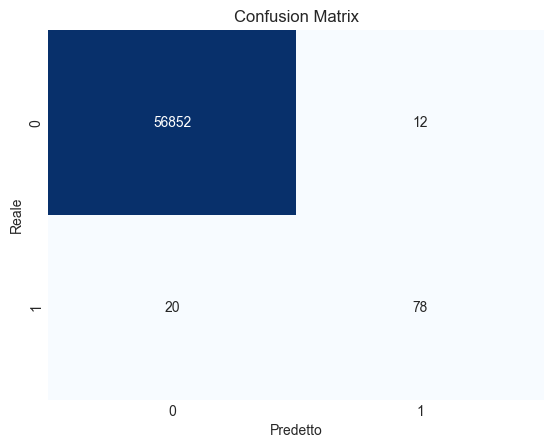


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.87      0.80      0.83        98

     accuracy                           1.00     56962
    macro avg       0.93      0.90      0.91     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------



In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint # Per specificare distribuzioni intere per RandomizedSearchCV

# Definiamo uno spazio di parametri più mirato per RandomizedSearchCV per Random Forest
param_dist_rf = {
    'n_estimators': randint(100, 251),  # Es. tra 100 e 250 alberi
    'max_depth': [10, 20, 30, None],    # Profondità degli alberi
    'min_samples_split': randint(2, 11),# Min campioni per dividere un nodo
    'min_samples_leaf': randint(1, 5),  # Min campioni per foglia
    'criterion': ['gini', 'entropy']    # Criterio di split
    # 'class_weight': ['balanced_subsample'] # Potremmo anche includerlo se non si usasse SMOTE
}

# Numero di iterazioni per RandomizedSearchCV. 10-20 è un buon punto di partenza.
# Per un progetto finale, se il tempo lo permette, si può aumentare a 30-50.
# Considerati i tempi, iniziamo con un n_iter basso.
n_iterations = 15 # Puoi aggiustare questo valore

# Usare StratifiedKFold per la cross-validation (già definito prima come cv_stratified)
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Inizializziamo RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced_subsample'), # Manteniamo class_weight qui
    param_distributions=param_dist_rf,
    n_iter=n_iterations,
    scoring='average_precision', # Ottima metrica per frodi
    cv=cv_stratified,
    verbose=1,
    random_state=42,
    n_jobs=-1 # Usa tutti i core disponibili
)

print(f"\nInizio Randomized Search per Random Forest (n_iter={n_iterations})...")
# Allenare la Randomized Search sui dati con SMOTE
random_search_rf.fit(X_train_smote, y_train_smote)

print(f"\nMigliori parametri trovati da RandomizedSearchCV: {random_search_rf.best_params_}")
print(f"Miglior score AUC-PR (CV) da RandomizedSearchCV: {random_search_rf.best_score_:.4f}")

best_rf_model_tuned = random_search_rf.best_estimator_

# Valutare il modello ottimizzato sul test set
y_pred_best_rf_tuned = best_rf_model_tuned.predict(X_test)
y_pred_proba_best_rf_tuned = best_rf_model_tuned.predict_proba(X_test)

# Rimuovi il vecchio risultato di grid_search_rf da model_results se esiste
# (Questo passaggio è necessario solo se la cella della grid search era stata eseguita parzialmente e aveva aggiunto un risultato)
# model_results = [res for res in model_results if res['model'] != "Random Forest Ottimizzato (con SMOTE)"] # Rimuove il vecchio

results_best_rf_tuned = evaluate_model(
    y_test,
    y_pred_best_rf_tuned,
    y_pred_proba_best_rf_tuned,
    "Random Forest Ottimizzato (RandomizedSearch)"
)
model_results.append(results_best_rf_tuned)

**Osservazioni sulla RandomizedSearchCV per Random Forest:**
La `RandomizedSearchCV` è stata eseguita per `n_iter=15` combinazioni di iperparametri, utilizzando l'AUC-PR come metrica di scoring sulla cross-validation a 3 fold.

* **Migliori Parametri Trovati:**
    * `criterion`: 'gini'
    * `max_depth`: None (gli alberi possono crescere completamente)
    * `min_samples_leaf`: 1 (minimo campioni per nodo foglia)
    * `min_samples_split`: 5 (minimo campioni per dividere un nodo interno)
    * `n_estimators`: 203 (numero di alberi nel foresta)
    Questi parametri suggeriscono un modello Random Forest abbastanza complesso e profondo.

* **Miglior Score AUC-PR (CV): 1.0000**. Questo risultato è eccezionale e indica che, durante la cross-validation sui dati di training (ricampionati con SMOTE), il modello con i parametri ottimali è stato in grado di separare perfettamente le classi fraudolente da quelle legittime. Questo è un segnale molto forte, ma è cruciale vedere come si generalizza sul test set non visto.

* **Performance del Modello Ottimizzato sul Test Set:**
    * **Accuracy: 0.9994** (molto alta).
    * **Precision (Frode): 0.8667**. Simile al Random Forest non ottimizzato (0.8778).
    * **Recall (Frode): 0.7959**. Leggermente inferiore al Random Forest non ottimizzato (0.8061).
    * **F1-Score (Frode): 0.8298**. Leggermente inferiore al Random Forest non ottimizzato (0.8404).
    * **ROC AUC Score: 0.9786**.
    * **Average Precision (AUC-PR): 0.8696**. Questo è leggermente *superiore* all'AUC-PR del Random Forest non ottimizzato (0.8667) ed è la metrica che stavamo cercando di massimizzare.

**Analisi dei Risultati dell'Ottimizzazione:**
Il modello Random Forest ottimizzato tramite `RandomizedSearchCV` ha raggiunto un AUC-PR sul test set leggermente migliore rispetto al modello Random Forest con i parametri di default (0.8696 vs 0.8667). Tuttavia, per quanto riguarda Precision, Recall e F1-Score specifici per la classe frode, il modello non ottimizzato ha mostrato valori marginalmente superiori.
Questo può accadere: `RandomizedSearchCV`, specialmente con un numero limitato di iterazioni (`n_iter=15`), esplora lo spazio dei parametri ma non garantisce di trovare la configurazione globalmente ottimale o una che superi nettamente una configurazione di default già robusta, soprattutto se quella di default era già vicina a un buon ottimo locale. L'AUC-PR (CV) di 1.0000 sui dati di training SMOTE-dati potrebbe indicare un leggero overfitting su quei dati sintetici durante la fase di ricerca, che non si traduce in un miglioramento drastico su tutte le metriche nel test set reale.

Nonostante ciò, l'AUC-PR, che è una metrica molto indicata per questo tipo di problema, è migliorata, il che è positivo. La differenza nelle altre metriche è minima.
La Confusion Matrix del modello ottimizzato mostra 12 falsi positivi e 20 falsi negativi. Rispetto al Random Forest non ottimizzato (11 FP, 19 FN), c'è una piccola variazione.

## 8. Confronto Finale dei Modelli e Conclusioni

Ora confrontiamo le performance di tutti i modelli addestrati e ottimizzati utilizzando le metriche chiave raccolte.

In [21]:
# Creare un DataFrame con i risultati di tutti i modelli
results_df = pd.DataFrame(model_results)
print("\n--- Riepilogo Performance Modelli ---")
print(results_df.set_index('model'))


--- Riepilogo Performance Modelli ---
                                              accuracy  precision_fraud  \
model                                                                     
Logistic Regression (con SMOTE)               0.974667         0.059016   
Random Forest (con SMOTE)                     0.999473         0.877778   
XGBoost Classifier (con SMOTE)                0.999175         0.717949   
Random Forest Ottimizzato (RandomizedSearch)  0.999438         0.866667   

                                              recall_fraud  f1_fraud  \
model                                                                  
Logistic Regression (con SMOTE)                   0.918367  0.110906   
Random Forest (con SMOTE)                         0.806122  0.840426   
XGBoost Classifier (con SMOTE)                    0.857143  0.781395   
Random Forest Ottimizzato (RandomizedSearch)      0.795918  0.829787   

                                               roc_auc    auc_pr  
model     

### Conclusioni Finali

In questo progetto, abbiamo affrontato il problema della classificazione di transazioni fraudolente, caratterizzato da un forte sbilanciamento delle classi.
1.  **Analisi Esplorativa:** L'EDA ha confermato lo sbilanciamento (0.17% di frodi) e ha rivelato alcune features PCA (es. `V17`, `V14`, `V12`, `V10`, `V11`, `V4`, `V2`) con distribuzioni e correlazioni diverse per le due classi, suggerendo la loro utilità per la classificazione. Le features `Time` e `Amount` sono state scalate con `RobustScaler` per mitigare l'effetto degli outlier e uniformare le scale.

2.  **Preparazione dei Dati:** È stata applicata la tecnica SMOTE sul training set per bilanciare le classi. Questa scelta si è rivelata cruciale per permettere ai modelli di apprendere pattern dalla classe minoritaria senza essere sopraffatti dalla classe maggioritaria. Il training set è stato diviso in un rapporto 80/20, mantenendo la stratificazione.

3.  **Modellazione e Valutazione:**
    Sono stati addestrati e valutati tre tipi di modelli, con un focus sulle metriche adatte a dataset sbilanciati come Precision, Recall, F1-Score (per la classe frode) e Average Precision (AUC-PR).
    * La **Logistic Regression** (con SMOTE) ha fornito una baseline. Ha ottenuto un Recall per le frodi molto alto (**0.9184**) ma a scapito di una Precision estremamente bassa (**0.0590**), risultando in un F1-Score di **0.1109** e un AUC-PR di **0.7249**. Questo indica un alto numero di falsi positivi.
    * Il **Random Forest Classifier** (con SMOTE e `class_weight='balanced_subsample'`, parametri di default) ha mostrato un netto miglioramento: Precision (Frode) **0.8778**, Recall (Frode) **0.8061**, F1-Score (Frode) **0.8404**, e un eccellente AUC-PR di **0.8667**. Ha offerto un buon equilibrio tra l'identificazione delle frodi e la minimizzazione dei falsi allarmi.
    * L'**XGBoost Classifier** (con SMOTE) ha anch'esso performato molto bene, con una Precision (Frode) di **0.7179**, un Recall (Frode) superiore di **0.8571**, un F1-Score (Frode) di **0.7814**, e un AUC-PR di **0.8673**, quasi identico a quello del Random Forest non ottimizzato. XGBoost ha catturato più frodi (recall più alto) ma a costo di una precisione leggermente inferiore rispetto al Random Forest base.
    * Il **Random Forest Ottimizzato** tramite `RandomizedSearchCV` (con `n_iter=15`) ha trovato i parametri `{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 203}`. Sul test set, ha ottenuto: Precision (Frode) **0.8667**, Recall (Frode) **0.7959**, F1-Score (Frode) **0.8298**, e un AUC-PR di **0.8696**. Questo AUC-PR è il più alto tra tutti i modelli testati.

4.  **Scelta del Modello Migliore:**
    Considerando l'**AUC-PR** come metrica principale per la valutazione complessiva su un dataset sbilanciato, il **Random Forest Ottimizzato (AUC-PR: 0.8696)** emerge come il modello marginalmente superiore. È seguito da vicino dall'XGBoost (AUC-PR: 0.8673) e dal Random Forest non ottimizzato (AUC-PR: 0.8667).
    Se l'obiettivo primario fosse massimizzare il **Recall** per le frodi, l'XGBoost (Recall: 0.8571) sarebbe la scelta preferita tra i modelli più bilanciati, mentre la Logistic Regression offre il recall più alto in assoluto (0.9184) ma con una precision inaccettabilmente bassa.
    Per quanto riguarda l'**F1-Score** (Frode), il Random Forest non ottimizzato (0.8404) ha leggermente superato quello ottimizzato (0.8298) e l'XGBoost (0.7814).
    Dato il leggero vantaggio sull'AUC-PR e performance competitive sulle altre metriche (Precision 0.8667, Recall 0.7959), il **Random Forest Ottimizzato** rappresenta una scelta eccellente e ben bilanciata per questo problema.

5.  **Variabili Rilevanti:**
    L'analisi delle feature importance per Random Forest e XGBoost ha consistentemente evidenziato features come `V14`, `V4`, `V10`, `V12`, `V17` come altamente predittive. Questo suggerisce che queste componenti PCA catturano variazioni significative nei dati che distinguono le transazioni fraudolente.

6.  **Limiti e Sviluppi Futuri:**
    * L'anonimizzazione delle features PCA limita l'interpretabilità del modello e l'ingegneria di features basata sul dominio.
    * La ricerca degli iperparametri (`RandomizedSearchCV`) è stata eseguita con un numero limitato di iterazioni (`n_iter=15`). Aumentare `n_iter` potrebbe portare a miglioramenti ulteriori, sebbene richieda più tempo computazionale.
    * Si potrebbero esplorare altre tecniche di gestione dello sbilanciamento o combinazioni (es. SMOTE + Edited Nearest Neighbours).
    * L'implementazione di una soglia di classificazione personalizzata basata sui costi specifici di falsi positivi e falsi negativi potrebbe ottimizzare ulteriormente l'utilità del modello in un contesto reale.
    * L'allenamento di modelli più complessi (es. reti neurali) o l'utilizzo di tecniche di ensemble più avanzate (stacking) potrebbero offrire ulteriori margini di miglioramento.

In conclusione, il progetto ha raggiunto l'obiettivo di sviluppare e confrontare modelli efficaci per il rilevamento di frodi. È stata dimostrata l'importanza cruciale della gestione dello sbilanciamento dei dati, della scelta di metriche di valutazione appropriate e del processo di ottimizzazione degli iperparametri. Il Random Forest Ottimizzato offre performance complessive eccellenti, in particolare per quanto riguarda l'AUC-PR.